#### Class imbalance strategies

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [42]:
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
# import the datasets
with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)

with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

In [12]:
# create a train-test split

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_training, 
    y_training, 
    test_size=0.2, 
    stratify=y_training, 
    random_state=42
)

In [32]:
cls , c = np.unique(y_train_split, return_counts=True)
print(f"Classes in testing split: {cls}")
print(f"Class counts in testing split: {c}")
print("-----------------------------------")
cls , c = np.unique(y_test_split, return_counts=True)
print(f"Classes in testing split: {cls}")
print(f"Class counts in testing split: {c}")

Classes in testing split: [0. 1. 2.]
Class counts in testing split: [136770   2964  22622]
-----------------------------------
Classes in testing split: [0. 1. 2.]
Class counts in testing split: [34193   741  5655]


#### Strategy 1: use the random forest classifier with a custom class weight dictionary

In [35]:
# we have around 2% prediabetes , 13% diabetes
# let's try some extreme class weight

for i in [100 , 200, 500 , 1000 , 3000]:

    # set custom class weight for prediabetes
    rf_classifier = RandomForestClassifier(
        n_estimators=400, 
        class_weight={ 0.:1 , 1.:i , 2.:20}, 
        random_state=42, 
        n_jobs=-1)

    # fit and predict
    rf_classifier.fit(x_train_split , y_train_split)
    y_pred = rf_classifier.predict(x_test_split)

    print(f"CLASSIFICATION REPORT PRE-DIAB WEIGHT: {i}\n")
    print(classification_report(y_test_split, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
    print(f"MCC PRE-DIAB WEIGHT {i}:  {matthews_corrcoef(y_test_split , y_pred)}")
    print("-----------------------------------------------------------")


CLASSIFICATION REPORT PRE-DIAB WEIGHT: 100

              precision    recall  f1-score   support

     Healthy       0.86      0.97      0.91     34193
    Pre-diab       0.00      0.00      0.00       741
        Diab       0.47      0.15      0.23      5655

    accuracy                           0.84     40589
   macro avg       0.44      0.37      0.38     40589
weighted avg       0.79      0.84      0.80     40589

MCC PRE-DIAB WEIGHT 100:  0.1883691561030925
-----------------------------------------------------------
CLASSIFICATION REPORT PRE-DIAB WEIGHT: 200

              precision    recall  f1-score   support

     Healthy       0.86      0.97      0.91     34193
    Pre-diab       0.00      0.00      0.00       741
        Diab       0.47      0.15      0.22      5655

    accuracy                           0.84     40589
   macro avg       0.44      0.37      0.38     40589
weighted avg       0.79      0.84      0.80     40589

MCC PRE-DIAB WEIGHT 200:  0.1875492805787873


#### Results:
Adjusting class weight in the RF classifier does not work at all (no emprovement even with extreme weight).  
I assume that this result holds true for other classifiers  

#### Strategy 2: undersampling of the most represented class

I will do undersampling using the BalancedRandomForest class from imbalance-learn  

from the documentation at https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier  

"A balanced random forest differs from a classical random forest by the fact that it will draw a bootstrap sample from the minority class and sample with replacement the same number of samples from the majority class."

In [41]:
brf_classifier = BalancedRandomForestClassifier(
    n_estimators=400,     
    sampling_strategy='all', 
    replacement=True,      
    random_state=42,
    n_jobs=-1,
)


brf_classifier.fit(x_train_split , y_train_split)
y_pred = brf_classifier.predict(x_test_split)

print(f"CLASSIFICATION REPORT:\n")
print(classification_report(y_test_split, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
print(f"MCC:  {matthews_corrcoef(y_test_split , y_pred)}")
print("-----------------------------------------------------------")

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

     Healthy       0.95      0.69      0.80     34193
    Pre-diab       0.03      0.10      0.04       741
        Diab       0.32      0.72      0.44      5655

    accuracy                           0.68     40589
   macro avg       0.43      0.50      0.43     40589
weighted avg       0.84      0.68      0.73     40589

MCC:  0.32114534070165457
-----------------------------------------------------------


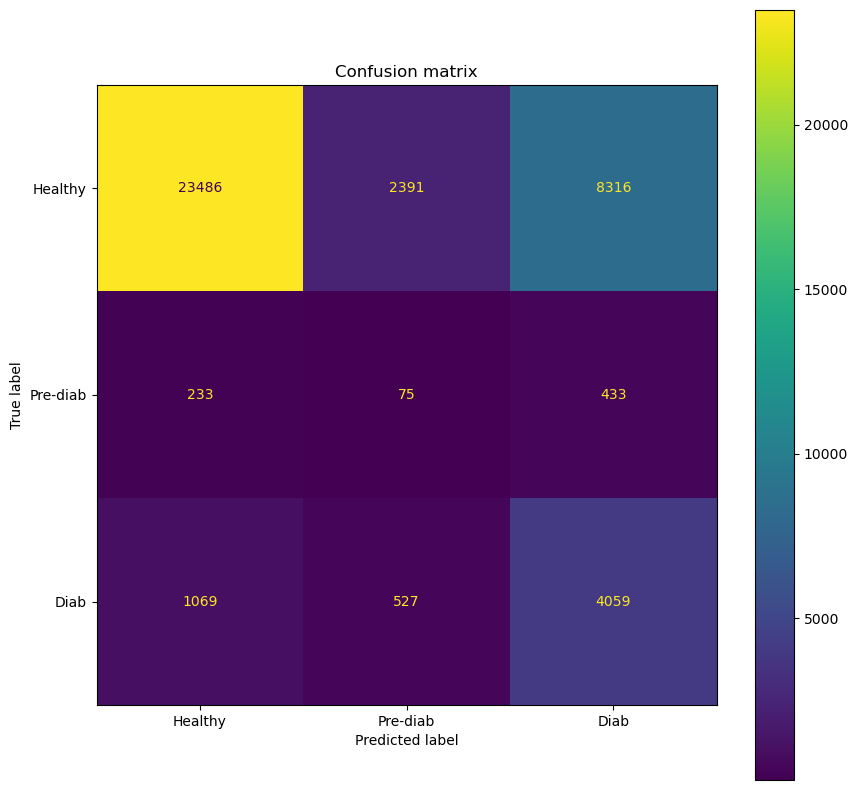

In [49]:
# we had a great improvement, but prediabetic precision is extremely low
# lets check where the pre-diabetics go

cm = confusion_matrix(y_test_split, y_pred, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diab', 'Diab'])

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='viridis', ax=ax, values_format='d') 
plt.title("Confusion matrix")
plt.show()

#### Results:  
the BalancedRandomForestClassifier class greately improved prediabetic classification    
More prediabetics were classified as diabetics instead of healthy, and this is good for the possible use case of the model  
But a good proportion of diabetics were classified as healthy.  

I will use this specific model to perform a second feature selection.